(sec:ols_in_practice)=
# Ordinary linear regression in practice

We often have situation where we have much more than just two datapoints, and they rarely  fall exactly on a straight line. Let's use python to generate some more realistic, yet artificial, data. Using the function below you can generate data from some linear process with random variables for the underlying parameters. We call this a data-generating process.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

def data_generating_process_reality(model_type, rng=np.random.default_rng(), **kwargs):
  if model_type == 'polynomial':
      true_params = rng.uniform(low=-5.0, high=5, size=(kwargs['poldeg']+1,))
      #polynomial model   
      def process(params, xdata):
          ydata = np.polynomial.polynomial.polyval(xdata,params)
          return ydata
      
  # use this to define a non-polynomial (possibly non-linear) data-generating process
  elif model_type == 'nonlinear':
      true_params = None
      def process(params, xdata):
          ydata = (0.5 + np.tan(np.pi*xdata))**2
          return ydata           
  else:
      print(f'Unknown Model')
      
  # return function for the true process the values for the true parameters
  # and the name of the model_type
  return process, true_params, model_type    

Next, we make some measurements of this process, and that typically entails some measurement errors. We will here assume that independently and identically distributed (i.i.d.) measurement errors $e_i$ that all follow a normal distribution with zero mean and variance $\sigma_e^2$. In a statistical notation we write $e_i \sim \mathcal{N}(0,\sigma_e^2)$. By default, we set $\sigma_e = 0.5$.

In [2]:
def data_generating_process_measurement(process, params, xdata, 
                           sigma_error=0.5, rng=np.random.default_rng()):
      
  ydata = process(params, xdata)
  
  #  sigma_error: measurement error. 
  error = rng.normal(0,sigma_error,len(xdata)).reshape(-1,1)

  return ydata+error, sigma_error*np.ones(len(xdata)).reshape(-1,)

Let us setup the data-generating process, in this case a linear process of polynomial degree 1, and decide how many measurements we make ($N_d=10$). All relevant output is stored in pandas dataframes.

In [3]:
#the number of data points to collect
# -----
Nd = 10
# -----

# predictor values
xmin = -1 ; xmax = +1
Xmeasurement = np.linspace(xmin,xmax,Nd).reshape(-1,1)
# store it in a pandas dataframe
pd_Xmeasurement = pd.DataFrame(Xmeasurement, columns=['x'])

# Define the data-generating process.
# Begin with a polynomial (poldeg=1) model_type
# in a second run of this notebook you can play with other linear models
reality, true_params, model_type = data_generating_process_reality(model_type='polynomial',poldeg=1)

print(f'model type      : {model_type}')
print(f'true parameters : {true_params}')
print(f'Nd = {Nd}')

# Collect measured data
# -----
sigma_e = 0.5
# -----
Ydata, Yerror = data_generating_process_measurement(reality,true_params,Xmeasurement,sigma_error=sigma_e)
# store the data in a pandas dataframe
pd_D=pd.DataFrame(Ydata,columns=['data'])
# 
pd_D['x'] = Xmeasurement
pd_D['e'] = Yerror

# We will also produce a denser grid for predictions with our model and comparison with the true process. This is useful for plotting
   
xreality = np.linspace(xmin,xmax,200).reshape(-1,1)
pd_R = pd.DataFrame(reality(true_params,xreality), columns=['data'])
pd_R['x'] = xreality

model type      : polynomial
true parameters : [3.18133599 2.84395685]
Nd = 10


Create some analysis tool to inspect the data, and later on the model.

In [4]:
# helper function to plot data, reality, and model (pd_M)
def plot_data(pd_D, pd_R, pd_M, with_errorbars = True):
    fig, ax = plt.subplots(1,1,figsize=(8,6))
    ax.scatter(pd_D['x'],pd_D['data'],label=r'Data',color='black',zorder=1, alpha=0.9,s=70,marker="d");
    if with_errorbars:
        ax.errorbar(pd_D['x'],pd_D['data'], pd_D['e'],fmt='o', ms=0, color='black');
    if pd_R is not None:
        ax.plot(pd_R['x'], pd_R['data'],color='red', linestyle='--',lw=3,label='Reality',zorder=10)
    if pd_M is not None:
        ax.plot(pd_M['x'], pd_M['data'],color='blue', linestyle='--',lw=3,label='Model',zorder=11)
    ax.legend();
    ax.set_title('Collected data');
    ax.set_xlabel(r'Predictor $x$');
    ax.set_ylabel(r'Response $y$');
    return fig,ax

Let's have a look at the data. We set the last two arguments to `None` for visualizing only the data.

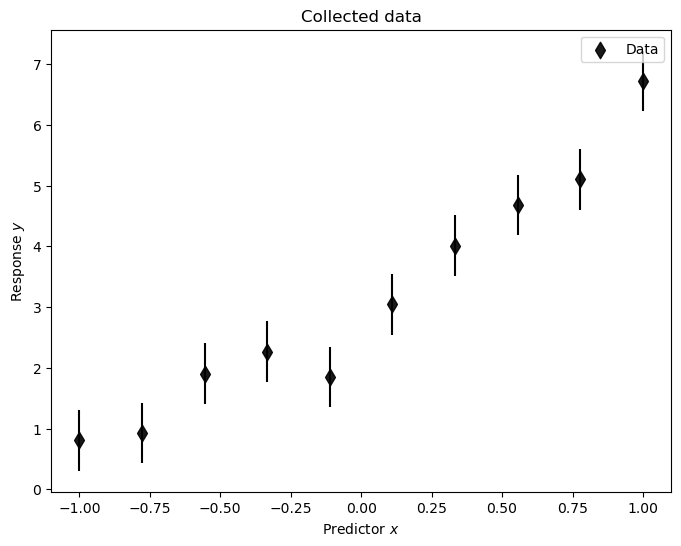

In [5]:
plot_data(pd_D, None, None);

Linear regression proceeds via the design matrix. We will analyze this data using a linear polynomial model of order 1. The following code will allow you to setup the corresponding design matrix $\dmat$ for any polynomial order (referred to as poldeg below)

In [6]:
def setup_polynomial_design_matrix(data_frame, poldeg, drop_constant=False, verbose=True):
    if verbose:
        print('setting up design matrix:')
        print('  len(data):', len(data_frame.index))

        # for polynomial models: x^0, x^1, x^2, ..., x^p
        # use numpy increasing vandermonde matrix
        print('  model poldeg:',poldeg)
    
    predictors = np.vander(data_frame['x'].to_numpy(), poldeg+1, increasing = True)
    if drop_constant:
        predictors = np.delete(predictors, 0, 1)
        if verbose:
            print('  dropping constant term')
    pd_design_matrix = pd.DataFrame(predictors)
        
    return pd_design_matrix

So, let's setup the design matrix for a model with polynomial basis functions. Note that there are $N_p$ parameters in a polynomial function of order $N_p-1$

$$
M(\pars;\inputt) = \theta_0 + \theta_1 \inputt.
$$

In [7]:
Np=2
pd_X = setup_polynomial_design_matrix(pd_Xmeasurement,poldeg=Np-1)

setting up design matrix:
  len(data): 10
  model poldeg: 1


We can now perform linear regression, or ordinary least squares (OLS), as

In [8]:
#ols estimator for physical parameter theta
D = pd_D['data'].to_numpy()
X = pd_X.to_numpy()

ols_cov   = np.linalg.inv(np.matmul(X.T,X))
ols_xTd   = np.matmul(X.T,D)
ols_theta = np.matmul(ols_cov,ols_xTd)

print(f'Ndata = {Nd}')
print(f'theta_ols \t{ols_theta}')
print(f'theta_true \t{true_params}\n')

Ndata = 10
theta_ols 	[3.13081656 2.80260819]
theta_true 	[3.18133599 2.84395685]



To evaluate the (fitted) model we setup a design matrix that spans dense values across the relevant range of predictors.

In [9]:
pd_Xreality = setup_polynomial_design_matrix(pd_R,poldeg=Np-1)

setting up design matrix:
  len(data): 200
  model poldeg: 1


and then we dot this with the fitted (ols) parameter values

In [10]:
Xreality = pd_Xreality.to_numpy()
pd_M_ols = pd.DataFrame(np.matmul(Xreality,ols_theta),columns=['data'])
pd_M_ols['x'] = xreality

A plot (which now includes the data-generating process 'reality') demonstrates the quality of the inference.

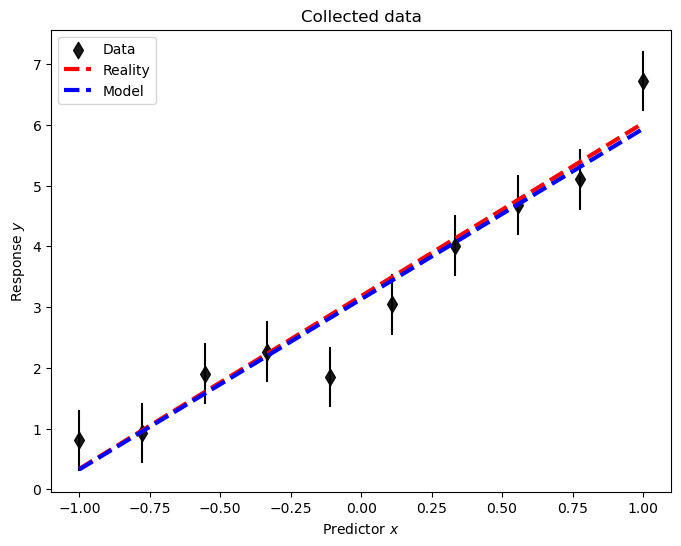

In [11]:
plot_data(pd_D, pd_R, pd_M_ols);

To conclude, we also compute the sample variance $s^2$

In [12]:
ols_D   = np.matmul(X,ols_theta)
ols_eps = (ols_D - D)
ols_s2 = (np.dot(ols_eps,ols_eps.T)/(Nd-Np))

print(f's^2       \t{ols_s2:.3f}')
print(f'sigma_e^2 \t{sigma_e**2:.3f}')

s^2       	0.263
sigma_e^2 	0.250


As seen, the extracted variance is in some agreement with the true one.

Using the code above, you should now try to do the following exercises.

```{exercise}
:label: exercise:ols_example_4
Keep working with the simple polynomial model $M = \theta_0 + \theta_1 x$

Reduce the number of data to 2, i.e., set Nd=2. Do you reproduce the result from the simple example in the previous section?

Increase the number of data to 1000. Do the OLS values of the model parameters and the sample variance approach the (true) parameters of the data-generating process? Is this to be expected? 
```

```{exercise}
:label: exercise:ols_example_5
Set the data-generating process to be a 3rd-order polynomial and set limits of the the predictor variable to [-3,3]. Analyze the data using a 2nd-order polynomial model.

Explore the limit of $N_d \rightarrow \infty$ by setting $N_d = 500$ or so. Will the OLS values of the model parameters and the sample variance approach the (true) values for some of the parameters? 
```